# PostSelecttML: Modeling Notebook Locally Run Modeling
### by Dolci Key 

 In following this notebook, I will run the current best model locally. 

## Import Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline 


import tensorflow as tf
from tensorflow import keras
from keras import layers, models, optimizers, metrics
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.metrics import Accuracy, Recall
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
from sklearn.utils import class_weight


from PIL import Image
import pydot
import graphviz

import pickle
from timeit import default_timer as timer

import os
import gc


## Importing Data 

Here we have the train, validation, and hold out set directories and then the paths to the reject(X) and select(y/target). 

In [2]:
# Train

train_dir = '/Volumes/DOLCI KEY 2019/Neural Network/compressed/TRAIN'

# Split X and Y if needed 
train_x = '/Volumes/DOLCI KEY 2019/Neural Network/compressed/TRAIN/reject'
train_y = '/Volumes/DOLCI KEY 2019/Neural Network/compressed/TRAIN/select'

# Validation 
validation_dir = '/Volumes/DOLCI KEY 2019/Neural Network/compressed/VALIDATION'

# Split X and Y if needed 
test_x = '/Volumes/DOLCI KEY 2019/Neural Network/compressed/VALIDATION/reject'
test_y = '/Volumes/DOLCI KEY 2019/Neural Network/compressed/VALIDATION/select'

# Test/Hold Out Set 

test_dir = '/Volumes/DOLCI KEY 2019/Neural Network/compressed/TEST'

# Split X and Y if needed 
hold_x = '/Volumes/DOLCI KEY 2019/Neural Network/compressed/TEST/reject'
hold_y = '/Volumes/DOLCI KEY 2019/Neural Network/compressed/TEST/select'

## Setting up the Training, Validation, and Test sets. 

for the training set, we will use the horizontal_flip to augment the minority class as well as adding zoom range up to 30%. We have included the target size of the images which are 500,333 pixels each, set the color mode to RGB (color), and the class mode is binary. 

In [3]:
#Training
train_set = image.ImageDataGenerator(rescale = 1/255, horizontal_flip = True, zoom_range = .3).flow_from_directory(train_dir,
                                                                  target_size = (500,333), 
                                                                  color_mode='rgb',
                                                                  class_mode = 'binary')



Found 1954 images belonging to 2 classes.


In [4]:
# Validation Set
validation_set = image.ImageDataGenerator(rescale = 1/255).flow_from_directory(validation_dir,
                                                                shuffle= True,
                                                                target_size = (500,333), 
                                                                color_mode='rgb',
                                                                class_mode='binary')

Found 698 images belonging to 2 classes.


In [5]:
# Test set / Hold out Set                                                               
test_set = image.ImageDataGenerator(rescale = 1/255).flow_from_directory(test_dir,
                                                                shuffle = False, 
                                                                target_size = (500,333), 
                                                                color_mode='rgb',
                                                                class_mode='binary')

Found 769 images belonging to 2 classes.


## Vanilla Model 

First, I will run a very simple model to get an idea of a baseline, or a starting point to really work from. The metrics I am most interested in is recall as I would much rather get a bad photo mixed in with the good ones occasionally, rather than a good one tossed out with the bad. 

In [6]:
# Vanilla model 

HEIGHT = 500
WIDTH = 333
DEPTH = 3

model = models.Sequential()
model.add(layers.Conv2D(32, 3, activation = 'relu', padding = 'same', input_shape=(HEIGHT, WIDTH, DEPTH)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [8]:
    model.compile(loss='binary_crossentropy',  
                optimizer=optimizers.RMSprop(lr=.0001),
                metrics = ['binary_accuracy', 'Recall', 'Precision'])

In [9]:
# Start timer to keep track of how long model is running for, not using class weights for this model
start = timer()

vanilla = model.fit(train_set, epochs = 5,
                            validation_data = validation_set)
end = timer()

# Take difference of time 
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

Epoch 1/5
62/62 [==============================] - 267s 4s/step - loss: 2.3639 - binary_accuracy: 0.8076 - recall: 0.1347 - precision: 0.1106 - val_loss: 5.1084 - val_binary_accuracy: 0.6819 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/5
62/62 [==============================] - 259s 4s/step - loss: 1.0492 - binary_accuracy: 0.8260 - recall: 0.0881 - precision: 0.0939 - val_loss: 3.4611 - val_binary_accuracy: 0.6819 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/5
62/62 [==============================] - 260s 4s/step - loss: 0.8237 - binary_accuracy: 0.8362 - recall: 0.0881 - precision: 0.1056 - val_loss: 3.2037 - val_binary_accuracy: 0.6819 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 4/5
62/62 [==============================] - 258s 4s/step - loss: 0.5425 - binary_accuracy: 0.8675 - recall: 0.0466 - precision: 0.1071 - val_loss: 2.2927 - val_binary_accuracy: 0.6819 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 5/5
62/62 [=======

## Model Summary, Evaluation, and Prediction on Unseen Data

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 500, 333, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 250, 166, 32)      0         
_________________________________________________________________
flatten (Flatten)            (None, 1328000)           0         
_________________________________________________________________
dense (Dense)                (None, 128)               169984128 
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 169,985,153
Trainable params: 169,985,153
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.evaluate(test_set)

25/25 [==============================] - 23s 909ms/step - loss: 0.4809 - binary_accuracy: 0.8375 - recall: 0.0000e+00 - precision: 0.0000e+00


[0.4808923900127411, 0.8374512195587158, 0.0, 0.0]

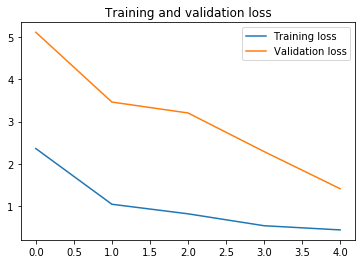

In [17]:
model_ = vanilla.history
epochs = vanilla.epoch
    
plt.figure()
plt.plot(epochs, model_['loss'], label='Training loss')
plt.plot(epochs, model_['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
    
plt.show();

In [20]:
model.save('SCRIPTS/vanilla\assets')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: SCRIPTS/vanillassets/assets


## Vanilla Model with Class Weights 

So now that I have an idea, let's see if weighting the classes helps with the scores. 

### Weighting the classes 
For later usage, we will weight the classes to help with class imbalance. 

In [22]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', [0, 1], train_set.classes)
weights = dict(zip([0, 1], weights))
weights

{0: 0.5547984099943214, 1: 5.062176165803109}

In [23]:
model = models.Sequential()
model.add(layers.Conv2D(32, 3, activation = 'relu', padding = 'same', input_shape=(HEIGHT, WIDTH, DEPTH)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [24]:
model.compile(loss ='binary_crossentropy',  
                optimizer = optimizers.RMSprop(lr = 0.0001), 
                weighted_metrics = 'Recall',
                metrics = 'binary_accuracy')

In [25]:
# Start timer to keep track of how long model is running for, not using class weights for this model
start = timer()

weighted_vanilla = model.fit(train_set, epochs = 5, class_weight = weights,
                            validation_data = validation_set)
end = timer()

# Take difference of time 
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

Epoch 1/5
62/62 [==============================] - 298s 5s/step - loss: 9.3953 - binary_accuracy: 0.5092 - recall: 0.4974 - val_loss: 1.4252 - val_binary_accuracy: 0.6117 - val_recall: 0.2117
Epoch 2/5
62/62 [==============================] - 314s 5s/step - loss: 4.2411 - binary_accuracy: 0.5589 - recall: 0.5440 - val_loss: 5.9393 - val_binary_accuracy: 0.3223 - val_recall: 0.9865
Epoch 3/5
62/62 [==============================] - 258s 4s/step - loss: 3.0163 - binary_accuracy: 0.5409 - recall: 0.5130 - val_loss: 1.2058 - val_binary_accuracy: 0.5272 - val_recall: 0.4685
Epoch 4/5
62/62 [==============================] - 256s 4s/step - loss: 2.0400 - binary_accuracy: 0.5302 - recall: 0.5078 - val_loss: 2.1385 - val_binary_accuracy: 0.6819 - val_recall: 0.0000e+00
Epoch 5/5
62/62 [==============================] - 256s 4s/step - loss: 1.3454 - binary_accuracy: 0.5860 - recall: 0.4870 - val_loss: 1.0353 - val_binary_accuracy: 0.5100 - val_recall: 0.4685
Total Time Elapsed:  23  minutes  38

## Model Summary, Evaluation, and Prediction on Unseen Data

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 500, 333, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 250, 166, 32)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1328000)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               169984128 
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 169,985,153
Trainable params: 169,985,153
Non-trainable params: 0
_________________________________________________________________


In [29]:
model.evaluate(test_set)

25/25 [==============================] - 20s 783ms/step - loss: 0.5559 - binary_accuracy: 0.7204 - recall: 0.1760


[0.5559000968933105, 0.7204161286354065, 0.17599999904632568]

In [30]:
model.save('SCRIPTS/weighted_vanilla\assets')

INFO:tensorflow:Assets written to: SCRIPTS/weighted_vanillassets/assets


## Iterative Modeling

In [31]:
HEIGHT = 500
WIDTH = 333
DEPTH = 3

model = models.Sequential()

model.add(layers.Conv2D(32, 3, activation = 'relu', input_shape=(HEIGHT, WIDTH, DEPTH)))
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(32, kernel_size=(3, 3), activation="relu"))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"))
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(64, kernel_size=(3, 3), activation="relu"))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128, kernel_size=(3, 3), activation="sigmoid", padding="same"))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(256, kernel_size=(3, 3), activation="sigmoid", padding="same"))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())

model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(256, activation="sigmoid"))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1, activation="sigmoid"))

In [32]:
model.compile(loss='binary_crossentropy',  
                optimizer=optimizers.RMSprop(lr= 0.0001),
                metrics = ['accuracy', 'binary_accuracy', 'Recall'])

In [33]:
# Start timer to keep track of how long model is running for
start = timer()

model_script = model.fit(train_set, epochs = 10, class_weight = weights,
                            validation_data = validation_set)
end = timer()

# Take difference of time 
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

Epoch 1/10
62/62 [==============================] - 310s 5s/step - loss: 0.7392 - accuracy: 0.5502 - binary_accuracy: 0.5502 - recall: 0.4974 - val_loss: 0.6429 - val_accuracy: 0.6819 - val_binary_accuracy: 0.6819 - val_recall: 0.0000e+00
Epoch 2/10
62/62 [==============================] - 285s 5s/step - loss: 0.7184 - accuracy: 0.5578 - binary_accuracy: 0.5578 - recall: 0.4560 - val_loss: 0.7451 - val_accuracy: 0.3181 - val_binary_accuracy: 0.3181 - val_recall: 1.0000
Epoch 3/10
62/62 [==============================] - 287s 5s/step - loss: 0.7223 - accuracy: 0.5614 - binary_accuracy: 0.5614 - recall: 0.4663 - val_loss: 0.8204 - val_accuracy: 0.3181 - val_binary_accuracy: 0.3181 - val_recall: 1.0000
Epoch 4/10
62/62 [==============================] - 292s 5s/step - loss: 0.7283 - accuracy: 0.4969 - binary_accuracy: 0.4969 - recall: 0.4508 - val_loss: 0.6688 - val_accuracy: 0.6819 - val_binary_accuracy: 0.6819 - val_recall: 0.0000e+00
Epoch 5/10
62/62 [==============================] - 

## Model Summary, Evaluation, and Prediction on Unseen Data

In [35]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 498, 331, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 249, 165, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 247, 163, 32)      9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 123, 81, 32)       0         
_________________________________________________________________
dropout (Dropout)            (None, 123, 81, 32)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 123, 81, 64)       18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 61, 40, 64)       

In [37]:
model.evaluate(test_set)

25/25 [==============================] - 27s 1s/step - loss: 0.6417 - accuracy: 0.8375 - binary_accuracy: 0.8375 - recall: 0.0000e+00


[0.6417186260223389, 0.8374512195587158, 0.8374512195587158, 0.0]

In [38]:
model.predict(test_set)

array([[0.46313015],
       [0.4632969 ],
       [0.46299884],
       [0.46296775],
       [0.46315953],
       [0.46331498],
       [0.46344033],
       [0.46269   ],
       [0.46334982],
       [0.46312323],
       [0.46315077],
       [0.46341652],
       [0.4627346 ],
       [0.46290025],
       [0.4632857 ],
       [0.46330187],
       [0.46075484],
       [0.4594261 ],
       [0.45942378],
       [0.45673564],
       [0.45630807],
       [0.45677593],
       [0.45695126],
       [0.45765364],
       [0.456746  ],
       [0.45712465],
       [0.45704153],
       [0.4574833 ],
       [0.4581632 ],
       [0.45774496],
       [0.45768788],
       [0.45742697],
       [0.45728296],
       [0.4570905 ],
       [0.45686704],
       [0.45731166],
       [0.4577876 ],
       [0.45682758],
       [0.4568015 ],
       [0.45711717],
       [0.45765013],
       [0.4575787 ],
       [0.45743614],
       [0.45728442],
       [0.4578729 ],
       [0.45831734],
       [0.45771492],
       [0.457

In [39]:
model.save('MODELS/model_script\assets')

INFO:tensorflow:Assets written to: MODELS/model_scriptssets/assets


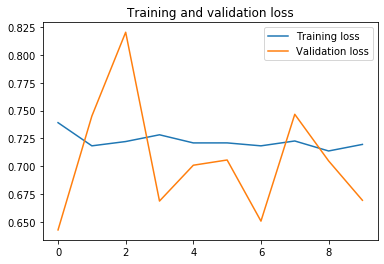

In [40]:
model_ = model_script.history
epochs = model_script.epoch
    
plt.figure()
plt.plot(epochs, model_['loss'], label='Training loss')
plt.plot(epochs, model_['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
    
plt.show();

## Testing Unseen Data

As we can see here, I have a lot of work left to do. 
The model rejects most images with around a .45 to .46 probability of being selected. 


reject image:  [[0.4606592]]


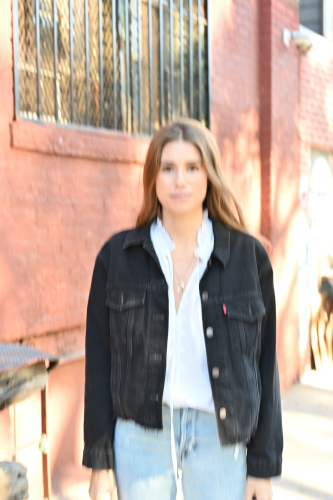

In [75]:
img_dir = 'THREE/DKP_3869_00015.jpg'
image = tf.keras.preprocessing.image.load_img(img_dir)
input_arr = keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])
predictions = model.predict(input_arr)
predictions

print ('reject image: ', predictions)
image

reject image:  [[0.46085235]]


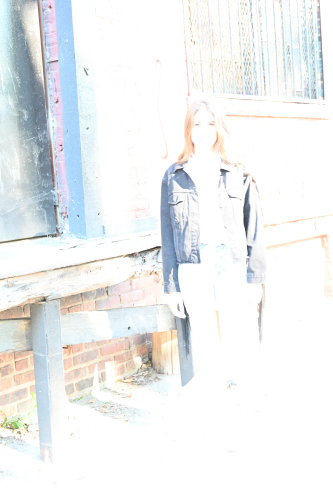

In [74]:
img_dir = 'THREE/DKP_3894_00033.jpg'
image = tf.keras.preprocessing.image.load_img(img_dir)
input_arr = keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])
predictions = model.predict(input_arr)
predictions

print ('reject image: ', predictions)
image

reject image:  [[0.46195698]]


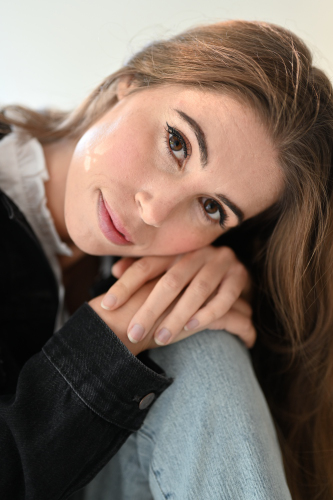

In [73]:
img_dir = 'THREE/DKP_4061_00073.jpg'
image = tf.keras.preprocessing.image.load_img(img_dir)
input_arr = keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])
predictions = model.predict(input_arr)


print ('reject image: ', predictions)
image